In [3]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.linear_model import LinearRegression

In [6]:
_dir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination'
# _dir = '/Users/pmahableshwarkar/Documents/Depth_Project/depth_discrimination'
# raw_dir = _dir + '/data/finalVEMatched/raw/'
zs_dir = _dir + '/data/finalDiscrimMatched/z_scored_RT/'

# final_data = pd.read_csv (raw_dir + '/raw_discrim.csv')
zscored_data = pd.read_csv (zs_dir + 'final_discrim.csv')

In [7]:
zscored_data.columns

Index(['Unnamed: 0', 'subjID', 'workerId', 'experimentName', 'versionName',
       'sequenceName', 'url', 'selected_row', 'windowWidth', 'windowHeight',
       'screenWidth', 'screenHeight', 'startDate', 'z_scored_RT', 'cleaned_RT',
       'startTime', 'trial', 'stimulus_0', 'stimulus_1', 'depth_difference',
       'kinect_answer', 'duration', 'actual_depth_0', 'actual_depth_1',
       'discrim_choice', 'trial_RT', 'log_fixation', 'log_sceneDuration1',
       'log_mask1', 'log_sceneDuration2', 'log_mask2', 'experimentTime',
       'totalTime', 'age', 'gender'],
      dtype='object')

In [8]:
def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        stimulus_duration = row['log_sceneDuration2']
        RT = row["trial_RT"] - stimulus_duration
        list_RTs.append(RT)
    
    if len(list_RTs) < 2:
        return list_RTs
    else:
        list_RTs = np.array(list_RTs)
        return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)
    
    
def get_zsRT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_zsRTs = []
    for idx, row in df.iterrows():   
        zsRT = row["z_scored_RT"]
        list_zsRTs.append(zsRT)
    
    list_zsRTs = np.array(list_zsRTs)
    return list_zsRTs, np.mean(list_zsRTs) ,np.std(list_zsRTs), stats.sem(list_zsRTs)
    
def get_accuracy(df):
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    if count_total == 0:
        return count_correct
    else:
#         standardError = (0.5*(1-0.5))/count_total
        p = count_correct/count_total
        standardError = np.sqrt((p*(1-p))/count_total)
    

    return count_correct/count_total, count_correct, count_total, count_missed, standardError

In [9]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = [elem for elem in df.stimulus_0.unique() if type(elem) == str]

    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_125_df = stim_df[stim_df['duration'] == 125.0]
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
                
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        kinect_answer = stim0_df.kinect_answer.unique()[0]
        

        try:
            stim_acc_125 = get_accuracy(stim_125_df)
            stim_acc_250 = get_accuracy(stim_250_df)
            stim_acc_1000 = get_accuracy(stim_1000_df)

            stim_RT_125 = get_RT(stim_125_df)
            stim_RT_250 = get_RT(stim_250_df)
            stim_RT_1000 = get_RT(stim_1000_df)
            
            stim_zsRT_125 = get_zsRT(stim_125_df)
            stim_zsRT_250 = get_zsRT(stim_250_df)
            stim_zsRT_1000 = get_zsRT(stim_1000_df)

            stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                    'accuracy_125': stim_acc_125,
                                    'RT_125': stim_RT_125,
                                    'zsRT_125': stim_zsRT_125,
                                    'accuracy_250': stim_acc_250,
                                    'RT_250': stim_RT_250,
                                    'zsRT_250': stim_zsRT_250,
                                    'accuracy_1000': stim_acc_1000,
                                    'RT_1000': stim_RT_1000,
                                    'zsRT_1000': stim_zsRT_1000,
                                    'avg_depth': stim_depthbin,
                                    'depthdifference': stim_depthdiff, 
                                    'kinect_answer': kinect_answer}
        except:
            pass
    
    return stimuli_stats

In [10]:
all_discrim_performance = individual_discrimination_stats(zscored_data)


In [13]:
len(all_discrim_performance)

156

### Prep accuracy data for plotting

In [14]:
final_stim = [key for key in all_discrim_performance]


In [15]:
# x = average depth of the targets 
final_x_125 = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_125 = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = proportion correct 
final_z_125 = [all_discrim_performance[key]['accuracy_125'][0] for key in all_discrim_performance]

ste_125 = [all_discrim_performance[elem]['accuracy_125'][-1] for elem in all_discrim_performance]

count_correct_125 = [all_discrim_performance[key]['accuracy_125'][1] for key in all_discrim_performance]
count_total_125 = [all_discrim_performance[key]['accuracy_125'][2] for key in all_discrim_performance]


final_x_125[0], final_y_125[0], final_z_125[0], ste_125[0], count_correct_125[0]

(1.4945, 0.31499999999999995, 0.3223684210526316, 0.03790978055308842, 49)

In [16]:
# x = average depth of the targets 
final_x_250 = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_250 = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = proportion correct 
final_z_250 = [all_discrim_performance[key]['accuracy_250'][0] for key in all_discrim_performance]

ste_250 = [all_discrim_performance[elem]['accuracy_250'][-1] for elem in all_discrim_performance]

count_correct_250 = [all_discrim_performance[key]['accuracy_250'][1] for key in all_discrim_performance]
count_total_250 = [all_discrim_performance[key]['accuracy_250'][2] for key in all_discrim_performance]


final_x_250[0], final_y_250[0], final_z_250[0], ste_250[0], count_correct_250[0]

(1.4945, 0.31499999999999995, 0.5789473684210527, 0.040046626855404326, 88)

In [17]:
# x = average depth of the targets 
final_x_1000 = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_1000 = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = proportion correct 
final_z_1000 = [all_discrim_performance[key]['accuracy_1000'][0] for key in all_discrim_performance]

ste_1000 = [all_discrim_performance[elem]['accuracy_1000'][-1] for elem in all_discrim_performance]

count_correct_1000 = [all_discrim_performance[key]['accuracy_1000'][1] for key in all_discrim_performance]
count_total_1000 = [all_discrim_performance[key]['accuracy_1000'][2] for key in all_discrim_performance]


final_x_1000[0], final_y_1000[0], final_z_1000[0], ste_1000[0], count_correct_1000[0]

(1.4945, 0.31499999999999995, 0.6474358974358975, 0.03825208693378967, 101)

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

In [18]:
# average accuracy per duration

np.mean(np.array(final_z_125)), np.mean(np.array(final_z_250)), np.mean(np.array(final_z_1000))

(0.5466688148395225, 0.6061560556694102, 0.632956586012514)

In [19]:
np.sum(np.array(count_correct_125))/np.sum(np.array(count_total_125))

0.546485260770975

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom_test.html

compare list of participant accuracy to 0.5 - t-test

In [14]:
stats.binom_test(np.sum(np.array(count_correct_125)), n=np.sum(np.array(count_total_125)), p=0.5, alternative='greater')

5.263256415222673e-47

In [15]:
stats.binom_test(np.sum(np.array(count_correct_250)), n=np.sum(np.array(count_total_250)), p=0.5, alternative='greater')

5.86534079332525e-237

In [16]:
stats.binom_test(np.sum(np.array(count_correct_1000)), n=np.sum(np.array(count_total_1000)), p=0.5, alternative='greater')

0.0

In [20]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

In [21]:
stats.pearsonr(final_y_125, final_z_125)

(0.28429204315021883, 0.0003222117937424972)

m: [0.17765936]
b: 0.4298147014122647
R-squared:  0.08082196579852607


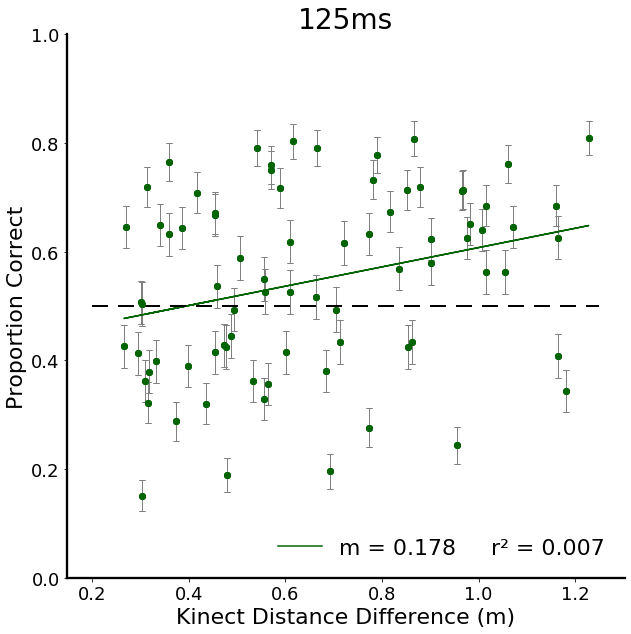

In [32]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[10,10])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X_125 = np.array(final_y_125).reshape(-1,1)
y_125 = final_z_125
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125, elinewidth=1, ecolor='gray', fmt='or', mfc='darkgreen', mec='darkgreen', capsize=3, yerr = np.array(ste_125));

plt.plot(X_125, y_125, 'o', color='darkgreen', alpha = 0.3);
plt.plot(X_125,y_predicted_125,color='darkgreen', label = 'm = ' + str(round(reg_125.coef_[0], 3))
         + '     r' + get_super('2')+  ' = '+ str(round(float(reg_125.score(X_125, y_125)**2), 3)))

plt.xlabel("Kinect Distance Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

# plt.plot([0.2, 1.25], [0.5,0.5], '--', color='black')

dash_pattern = [8, 5]
plt.plot([0.2, 1.25], [0.5,0.5], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)


plt.ylim([0,1])


legend = plt.legend(loc = 4, fontsize=22, labelspacing=1, frameon=False)


plt.title('125ms', fontsize=28)

plt.xticks(np.arange(0.2,1.3, 0.2), fontsize=18)
plt.yticks(np.arange(0,1.2, 0.2), fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

residuals_125 = y_125 - y_predicted_125

d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
plt.savefig(d + 'kinectDepthDiff_PC_125.png', dpi=300)

In [24]:
stats.pearsonr(final_y_250, final_z_250)

(0.23133421119861877, 0.0036649581777854737)

m: [0.15487163]
b: 0.5042903976534031
R-squared:  0.05351551727088711


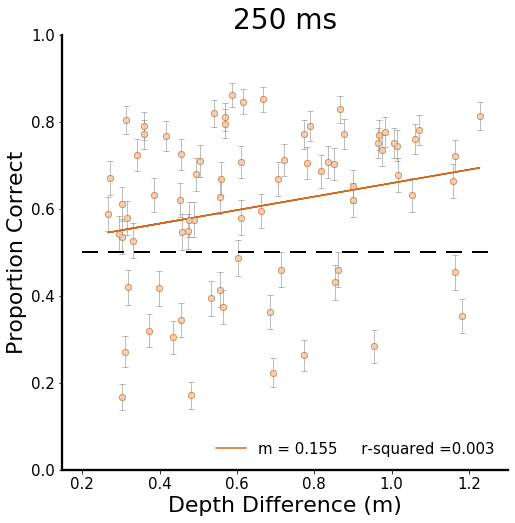

In [25]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X_250 = np.array(final_y_250).reshape(-1,1)
y_250 = final_z_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(ste_250));

plt.plot(X_250, y_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared ='+ str(round(float(reg_250.score(X_250, y_250)**2), 3)))

plt.xlabel("Depth Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

# plt.plot([0.2, 1.25], [0.5,0.5], '--', color='black')

dash_pattern = [8, 5]
plt.plot([0.2, 1.25], [0.5,0.5], color='black', linestyle='--', dashes=dash_pattern, linewidth=2)


plt.ylim([0,1])
plt.title('250 ms', fontsize=28)


legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)


plt.xticks(np.arange(0.2,1.3, 0.2), fontsize=15)
plt.yticks(np.arange(0,1.2, 0.2), fontsize=15)



#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

residuals_250 = y_250 - y_predicted_250


In [23]:
stats.pearsonr(final_y_1000, final_z_1000)

(0.2716023643310843, 0.0006041754392579866)

m: [0.20256224]
b: 0.49972278629979117
R-squared:  0.07376784431023486


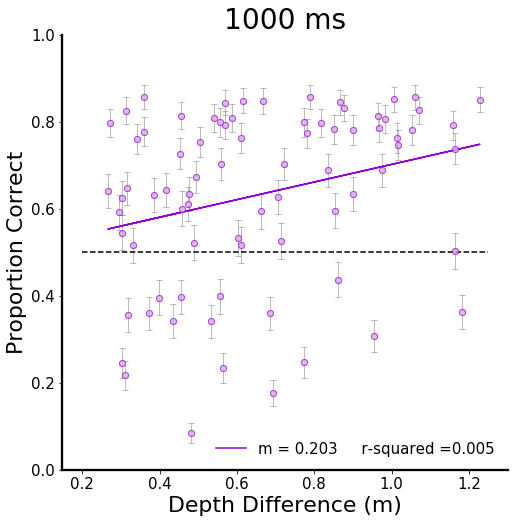

In [24]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X_1000 = np.array(final_y_1000).reshape(-1,1)
y_1000 = final_z_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(ste_1000));

r = np.sqrt(round(float(reg_1000.score(X_1000, y_1000)), 3))
plt.plot(X_1000, y_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'm = ' + str(round(reg_1000.coef_[0], 3))
         + '     r-squared ='+ str(round(float(reg_1000.score(X_1000, y_1000)**2), 3)))

plt.xlabel("Depth Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.plot([0.2, 1.25], [0.5,0.5], '--', color='black')

plt.ylim([0,1])

plt.title('1000 ms', fontsize=28)


legend = plt.legend(loc = 4, fontsize=15, labelspacing=1, frameon=False)


plt.xticks(np.arange(0.2,1.3, 0.2), fontsize=15)
plt.yticks(np.arange(0,1.2, 0.2), fontsize=15)


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

residuals_1000 = y_1000 - y_predicted_1000


## Save residuals 

In [20]:
residuals_125[0], residuals_250[0]

(-0.16340897781920433, 0.02587240654588041)

In [23]:
destpath = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_discrimination/data/finalDiscrimMatched/kinectCoded_discrimination/'

with open(destpath + 'residuals_125.npy', 'wb') as f:
    np.save(f, residuals_125)
with open(destpath + 'residuals_250.npy', 'wb') as f:
    np.save(f, residuals_250)
with open(destpath + 'residuals_1000.npy', 'wb') as f:
    np.save(f, residuals_1000)
    
    
with open(destpath + 'final_stim.npy', 'wb') as f:
    np.save(f, final_stim)


m: [0.20256224]
b: 0.49972278629979117
R-squared:  0.07376784431023486


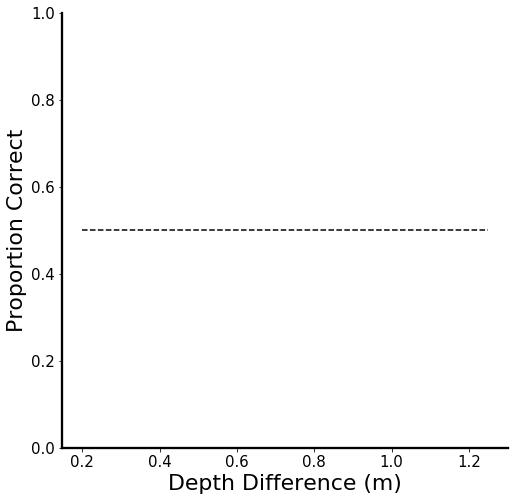

In [21]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


plt.xlabel("Depth Difference (m)", fontsize = 22)
plt.ylabel("Proportion Correct", fontsize = 22)

plt.plot([0.2, 1.25], [0.5,0.5], '--', color='black')

plt.ylim([0,1])





plt.xticks(np.arange(0.2,1.3, 0.2), fontsize=15)
plt.yticks(np.arange(0,1.2, 0.2), fontsize=15)


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

In [22]:
sem(np.array(final_z_125)), sem(np.array(final_z_250)), sem(np.array(final_z_1000))

(0.013459803422201495, 0.014419405269194364, 0.01606350395839347)

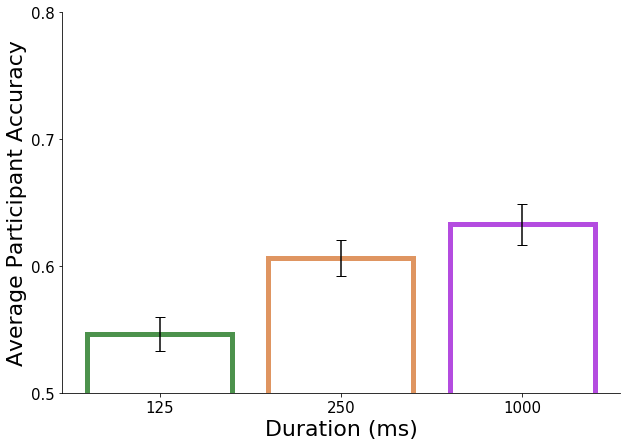

In [23]:
# creating the dataset
durations = ['125', '250', '1000']

zs_PC = [np.mean(np.array(final_z_125)), 
         np.mean(np.array(final_z_250)),
         np.mean(np.array(final_z_1000))]

fig, ax = plt.subplots(figsize=[10,7])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xticks(fontsize=15)
plt.ylim(0.5, 0.80)
plt.yticks(np.arange(0.5, 0.80, 0.1),fontsize=15)



# creating the bar plot
plt.bar(durations, zs_PC, yerr = [sem(np.array(final_z_125)),sem(np.array(final_z_250)),sem(np.array(final_z_1000))], color='white', edgecolor = ['darkgreen', 'chocolate', 'darkviolet'], width=0.8, capsize=5, alpha=0.7, linewidth=5)
# plt.bar(durations, zs_PC, color = ['gray'], width=0.8, capsize=5, alpha=0.5)

# plt.title('Verbal Estimate Defined Discrimination Accuracy', fontsize=20)
plt.xlabel("Duration (ms)", fontsize=22)
plt.ylabel("Average Participant Accuracy", fontsize=22)

plt.show()

In [24]:
len(final_z_125) + len(final_z_250) 

312

In [25]:
# Proportion Correct by duration
fvalue, pvalue = stats.f_oneway(final_z_125, final_z_250, final_z_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_z_125, final_z_250)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_z_250, final_z_1000)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_z_125, final_z_1000)
print(fvalue, pvalue)

9.042023636851049 0.00014045418691710894
9.094996621188201 0.002775120257303865
1.5414960632339794 0.2153338369759673
16.95249913993464 4.9199074548985936e-05


In [26]:
print(stats.ttest_ind(final_z_125, final_z_250))

print(stats.ttest_ind(final_z_250, final_z_1000))

print(stats.ttest_ind(final_z_125, final_z_1000))


Ttest_indResult(statistic=-3.015791209813467, pvalue=0.0027751202573039063)
Ttest_indResult(statistic=-1.24156999932907, pvalue=0.21533383697596295)
Ttest_indResult(statistic=-4.117341270763772, pvalue=4.919907454898504e-05)


### Prep RT data for plotting

In [26]:
# x = average depth of the targets 
final_x_125_RT = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_125_RT = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = average RT 
final_z_125_RT = [all_discrim_performance[key]['zsRT_125'][1] for key in all_discrim_performance]

final_125_RT_ste = [all_discrim_performance[key]['zsRT_125'][-1] for key in all_discrim_performance]

# z = average RT 
final_raw_125_RT = [all_discrim_performance[key]['RT_125'][1] for key in all_discrim_performance]

final_raw_125_RT_ste = [all_discrim_performance[key]['RT_125'][-1] for key in all_discrim_performance]

In [27]:
# x = average depth of the targets 
final_x_250_RT = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_250_RT = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = average RT 
final_z_250_RT = [all_discrim_performance[key]['zsRT_250'][1] for key in all_discrim_performance]

final_250_RT_ste = [all_discrim_performance[key]['zsRT_250'][-1] for key in all_discrim_performance]

# z = average RT 
final_raw_250_RT = [all_discrim_performance[key]['RT_250'][1] for key in all_discrim_performance]

final_raw_250_RT_ste = [all_discrim_performance[key]['RT_250'][-1] for key in all_discrim_performance]

final_x_250_RT[0], final_y_250_RT[0], final_z_250_RT[0], final_250_RT_ste[0]

(1.4945, 0.31499999999999995, 0.12480927435435656, 0.09650660125390263)

In [28]:
# x = average depth of the targets 
final_x_1000_RT = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_1000_RT = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = average RT 
final_z_1000_RT = [all_discrim_performance[key]['zsRT_1000'][1] for key in all_discrim_performance]

final_1000_RT_ste = [all_discrim_performance[key]['zsRT_1000'][-1] for key in all_discrim_performance]

# z = average RT 
final_raw_1000_RT = [all_discrim_performance[key]['RT_1000'][1] for key in all_discrim_performance]

final_raw_1000_RT_ste = [all_discrim_performance[key]['RT_1000'][-1] for key in all_discrim_performance]

final_x_1000_RT[0], final_y_1000_RT[0], final_z_1000_RT[0], final_1000_RT_ste[0]

(1.4945, 0.31499999999999995, 0.04402711103151411, 0.09436713109071909)

m: [-43.44389393]
b: 1401.4050169304157
R-squared:  0.014198864778334097


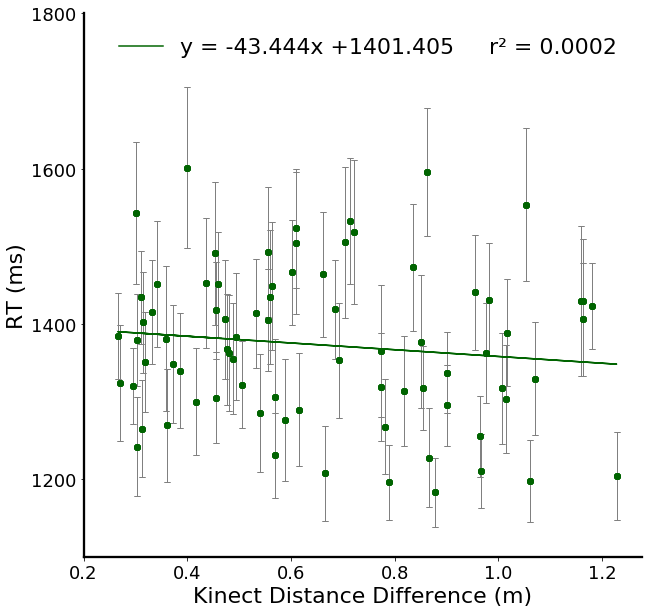

In [30]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X_125 = np.array(final_y_125).reshape(-1,1)
y_125 = final_raw_125_RT
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='darkgreen', mec='darkgreen', capsize=3, yerr = np.array(final_raw_125_RT_ste));

plt.plot(X_125, y_125, 'o', color='darkgreen');
plt.plot(X_125, y_predicted_125,color='darkgreen', label = 'y = ' + str(round(reg_125.coef_[0], 3)) + 'x +' + str(round(reg_125.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg_125.score(X_125, y_125)**2), 4)))


plt.xlabel("Kinect Distance Difference (m)", fontsize = 22)
plt.ylabel("RT (ms)", fontsize = 22)


legend = plt.legend(loc = 1, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


plt.ylim(1100, 1800)


plt.xticks(np.arange(0.2,1.4,0.2), fontsize=18)
plt.yticks(np.arange(1200,2000,200), fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
plt.savefig(d + 'RT_KinectDepthDiff_125.png', dpi=300)

In [30]:
#run regression
X = np.array(final_y_250).reshape(-1,1)
y = final_raw_250_RT
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

print('250: Raw RT x Kinect Depth Diff')

#get coefficients and y intercept
print("m: {0}".format(reg.coef_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y)**2)


250: Raw RT x Kinect Depth Diff
m: [-31.87884203]
R-squared:  0.0001438199381762725


In [31]:
#run regression
X = np.array(final_y_1000).reshape(-1,1)
y = final_raw_1000_RT
reg = LinearRegression().fit(X, y)

#Generated Predictions
y_predicted = reg.predict(X)

print('1000: Raw RT x Kinect Depth Diff')


#get coefficients and y intercept
print("m: {0}".format(reg.coef_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg.score(X, y)**2)

1000: Raw RT x Kinect Depth Diff
m: [-15.96813345]
R-squared:  1.4317953346137653e-05


m: [-0.07752095]
b: 0.05117171861322867
R-squared:  0.013978338033972191


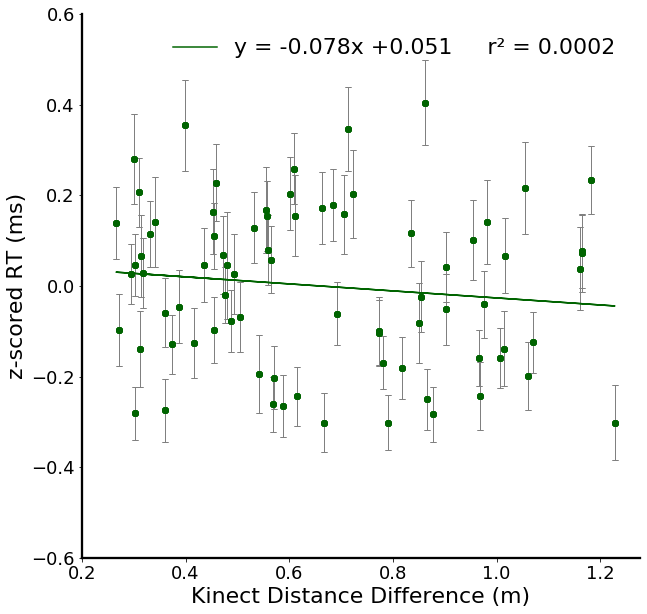

In [31]:
fig, ax = plt.subplots(figsize=[10,10])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(2.3)


#run regression
X_125 = np.array(final_y_125).reshape(-1,1)
y_125 = final_z_125_RT
reg_125 = LinearRegression().fit(X_125, y_125)

#Generated Predictions
y_predicted_125 = reg_125.predict(X_125)
#Plot Our Actual and Predicted Values
plt.errorbar(X_125, y_125,elinewidth=1, ecolor='gray',fmt='or', mfc='darkgreen', mec='darkgreen', capsize=3, yerr = np.array(final_125_RT_ste));

plt.plot(X_125, y_125, 'o', color='darkgreen');
plt.plot(X_125, y_predicted_125,color='darkgreen', label = 'y = ' + str(round(reg_125.coef_[0], 3)) + 'x +' + str(round(reg_125.intercept_, 3))
         + '     r' + get_super('2') + ' = ' + str(round(float(reg_125.score(X_125, y_125)**2), 4)))


plt.xlabel("Kinect Distance Difference (m)", fontsize = 22)
plt.ylabel("z-scored RT (ms)", fontsize = 22)


legend = plt.legend(loc = 1, fontsize = 22, borderpad = 0.6, labelspacing = 1, frameon=False)


plt.ylim(-0.6, 0.6)


plt.xticks(np.arange(0.2,1.4,0.2), fontsize=18)
plt.yticks(fontsize=18)

#get coefficients and y intercept
print("m: {0}".format(reg_125.coef_))
print("b: {0}".format(reg_125.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_125.score(X_125, y_125))

d = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/spatial_perception_SUNRGBD/figures-presentations/figures/'
plt.savefig(d + 'zsRT_KinectDepthDiff_125.png', dpi=300)

m: [-0.07866375]
b: 0.05152285735822627
R-squared:  0.00029843536618568


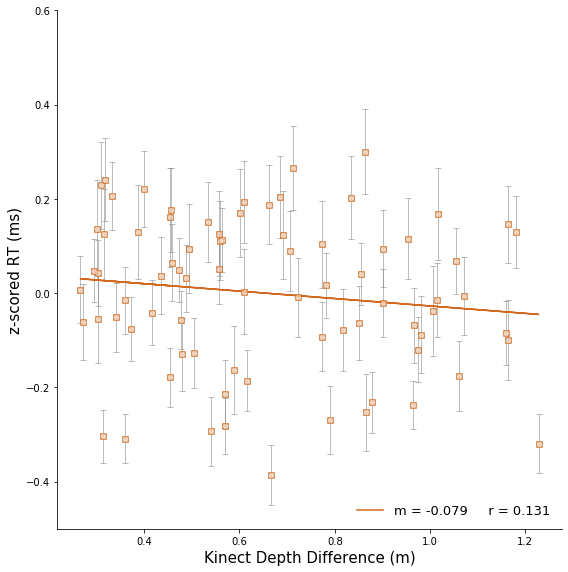

In [33]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(final_y_250).reshape(-1,1)
y_250 = final_z_250_RT
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(final_250_RT_ste));

r = np.sqrt(float(reg_250.score(X_250, y_250)))
plt.plot(X_250, y_250, 's', color='chocolate', alpha = 0.3);
plt.plot(X_250,y_predicted_250, '-',color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r = ' + str(round(r, 3)))

plt.xlabel("Kinect Depth Difference (m)", fontsize = 15)
plt.ylabel("z-scored RT (ms)", fontsize = 15)


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.ylim(-0.5, 0.6)

# plt.xticks(np.arange(0.15,1.2, 0.2))
# plt.yticks(np.arange(900,1500, 100))


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250)**2)

In [34]:
stats.pearsonr(final_y_125, final_z_125_RT), stats.pearsonr(final_y_250, final_z_250_RT), stats.pearsonr(final_y_1000, final_z_1000_RT)

((-0.11823002171179955, 0.14156798848126664),
 (-0.13143546683559965, 0.1019382207127956),
 (-0.11651945897791859, 0.14745993331970317))

m: [-3.94573059e-05]
b: 0.09912063893194062
R-squared:  3.4262850425125453e-16


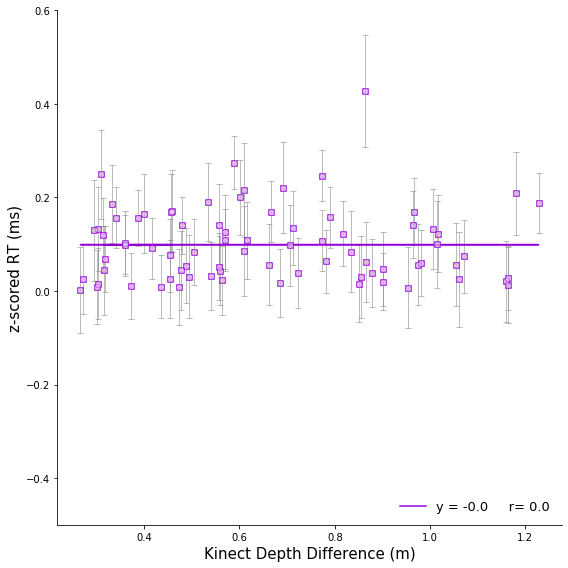

In [35]:

fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(final_y_1000).reshape(-1,1)
y_1000 = np.abs(final_z_1000_RT)
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(final_1000_RT_ste));

r = np.sqrt(float(reg_1000.score(X_1000, y_1000)))

plt.plot(X_1000, y_1000, 's', color='darkviolet', alpha = 0.3);
plt.plot(X_1000,y_predicted_1000, color='darkviolet', label = 'y = ' + str(round(reg_1000.coef_[0], 3))
         +'     r= ' + str(round(r, 3)))

plt.xlabel("Kinect Depth Difference (m)", fontsize = 15)
plt.ylabel("z-scored RT (ms)", fontsize = 15)


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

plt.ylim(-.5, .6)

fig.tight_layout()

# plt.xticks(np.arange(0.15,1.2, 0.2))
# plt.yticks(np.arange(900,1500, 100))


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000)**2)


In [36]:
fvalue, pvalue = stats.f_oneway(final_z_125_RT, final_z_250_RT, final_z_1000_RT)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_z_125_RT, final_z_250_RT)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_z_250_RT, final_z_1000_RT)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_z_125_RT, final_z_1000_RT)
print(fvalue, pvalue)

0.00026559324081581185 0.9997344421776194
0.000438787513494188 0.9833012065530223
7.012341441554479e-05 0.9933240010509451
0.00022971082983621723 0.9879173031433498


# Raw RT x Kinect Depth Diff: Stats

In [37]:
stats.pearsonr(final_y_125, final_raw_125_RT), stats.pearsonr(final_y_250, final_raw_250_RT), stats.pearsonr(final_y_1000, final_raw_1000_RT)


((-0.11915898949862619, 0.13844417207872797),
 (-0.10951025101415619, 0.17355199326820375),
 (-0.0615134713170792, 0.44555481496041105))

In [38]:
fvalue, pvalue = stats.f_oneway(final_raw_125_RT, final_raw_250_RT, final_raw_1000_RT)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_raw_125_RT, final_raw_250_RT)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_raw_250_RT, final_raw_1000_RT)
print(fvalue, pvalue)

fvalue, pvalue = stats.f_oneway(final_raw_125_RT, final_raw_1000_RT)
print(fvalue, pvalue)

70.15300326659221 2.363893377335071e-27
78.30758829625655 6.871470120423186e-17
148.3183074454391 3.7859807180754916e-28
1.9285396532849255 0.16591523160302393


In [41]:
print(stats.ttest_ind(final_raw_125_RT, final_raw_250_RT))
print(stats.ttest_ind(final_raw_250_RT, final_raw_1000_RT))
print(stats.ttest_ind(final_raw_125_RT, final_raw_1000_RT))

Ttest_indResult(statistic=8.84915749075901, pvalue=6.871470120423922e-17)
Ttest_indResult(statistic=-12.178600389430564, pvalue=3.7859807180765508e-28)
Ttest_indResult(statistic=-1.3887187092009987, pvalue=0.1659152316030274)


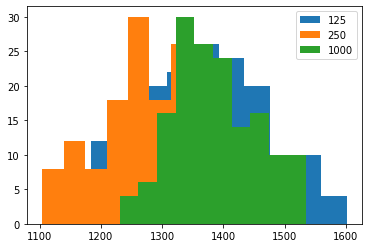

In [50]:
plt.hist(final_raw_125_RT, label='125')
plt.hist(final_raw_250_RT, label='250')
plt.hist(final_raw_1000_RT, label='1000')

plt.legend()

plt.show()

# Accuracy by Participant

In [13]:
acc_perSubj_by_duration = {'125': [], '250': [], '1000': []}

for subj in zscored_data.subjID.unique():
    subj_df = zscored_data.loc[zscored_data['subjID']==subj]
    duration = str(int(subj_df.duration.unique()[0]))
    subj_acc = get_accuracy(subj_df)[0]
    acc_perSubj_by_duration[duration].append(subj_acc)
    

In [18]:
acc_perSubj_by_duration['125']

# Importing library
import scipy.stats as stats
  
# Performing the paired sample t-test
print('125 Subj Accuracy x Chance')
print(stats.ttest_rel(acc_perSubj_by_duration['125'], [0.5]*len(acc_perSubj_by_duration['125'])))

print('250 Subj Accuracy x Chance')
print(stats.ttest_rel(acc_perSubj_by_duration['250'], [0.5]*len(acc_perSubj_by_duration['250'])))

print('1000 Subj Accuracy x Chance')
print(stats.ttest_rel(acc_perSubj_by_duration['1000'], [0.5]*len(acc_perSubj_by_duration['1000'])))

125 Subj Accuracy x Chance
Ttest_relResult(statistic=2.863819146382142, pvalue=0.004769738204675634)
250 Subj Accuracy x Chance
Ttest_relResult(statistic=7.062204504256518, pvalue=5.285878375404695e-11)
1000 Subj Accuracy x Chance
Ttest_relResult(statistic=8.213621444846817, pvalue=7.891653416278576e-14)


In [19]:
VE_acc_perSubj_125 = [0.6666666666666666,
 0.6025641025641025,
 0.8076923076923077,
 0.631578947368421,
 0.01282051282051282,
 0.8333333333333334,
 0.6794871794871795,
 0.4805194805194805,
 0.7051282051282052,
 0.37662337662337664,
 0.5512820512820513,
 0.7307692307692307,
 0.7307692307692307,
 0.5256410256410257,
 0.5128205128205128,
 0.5897435897435898,
 0.8333333333333334,
 0.46153846153846156,
 0.5897435897435898,
 0.6410256410256411,
 0.6410256410256411,
 0.5256410256410257,
 0.4230769230769231,
 0.01282051282051282,
 0.5769230769230769,
 0.8461538461538461,
 0.5128205128205128,
 0.6410256410256411,
 0.45454545454545453,
 0.5394736842105263,
 0.7435897435897436,
 0.3333333333333333,
 0.5897435897435898,
 0.6666666666666666,
 0.8589743589743589,
 0.7692307692307693,
 0.8205128205128205,
 0.7142857142857143,
 0.1794871794871795,
 0.6103896103896104,
 0.6538461538461539,
 0.4189189189189189,
 0.6923076923076923,
 0.6666666666666666,
 0.5256410256410257,
 0.6282051282051282,
 0.6923076923076923,
 0.7435897435897436,
 0.8076923076923077,
 0.5324675324675324,
 0.4358974358974359,
 0.6282051282051282,
 0.5769230769230769,
 0.7692307692307693,
 0.4805194805194805,
 0.5,
 0.0,
 0.6923076923076923,
 0.618421052631579,
 0.16216216216216217,
 0.782051282051282,
 0.7692307692307693,
 0.6794871794871795,
 0.5512820512820513,
 0.6233766233766234,
 0.7948717948717948,
 0.7307692307692307,
 0.46153846153846156,
 0.782051282051282,
 0.8717948717948718,
 0.013157894736842105,
 0.01282051282051282,
 0.8076923076923077,
 0.717948717948718,
 0.6666666666666666,
 0.7564102564102564,
 0.6666666666666666,
 0.5394736842105263,
 0.5897435897435898,
 0.3246753246753247,
 0.5769230769230769,
 0.8461538461538461,
 0.6923076923076923,
 0.5641025641025641,
 0.012987012987012988,
 0.5641025641025641,
 0.6923076923076923,
 0.7307692307692307,
 0.782051282051282,
 0.5384615384615384,
 0.6538461538461539,
 0.6025641025641025,
 0.32051282051282054,
 0.782051282051282,
 0.0,
 0.5769230769230769,
 0.6538461538461539,
 0.8717948717948718,
 0.5512820512820513,
 0.6410256410256411,
 0.5,
 0.782051282051282,
 0.7948717948717948,
 0.42105263157894735,
 0.8076923076923077,
 0.6666666666666666,
 0.7922077922077922,
 0.7435897435897436,
 0.782051282051282,
 0.410958904109589,
 0.5256410256410257,
 0.7435897435897436,
 0.8333333333333334,
 0.6410256410256411,
 0.6410256410256411,
 0.7051282051282052,
 0.717948717948718,
 0.013513513513513514,
 0.6282051282051282,
 0.7435897435897436,
 0.7051282051282052,
 0.5,
 0.6410256410256411,
 0.782051282051282,
 0.7051282051282052,
 0.012987012987012988,
 0.5256410256410257,
 0.38961038961038963,
 0.8076923076923077,
 0.8461538461538461,
 0.6282051282051282,
 0.47435897435897434,
 0.5584415584415584,
 0.8205128205128205,
 0.7435897435897436,
 0.6923076923076923,
 0.3333333333333333,
 0.0,
 0.8051948051948052,
 0.6666666666666666,
 0.013157894736842105,
 0.7012987012987013,
 0.01282051282051282,
 0.7051282051282052,
 0.8076923076923077,
 0.7051282051282052,
 0.782051282051282,
 0.5641025641025641,
 0.4861111111111111,
 0.7051282051282052,
 0.47435897435897434,
 0.6923076923076923,
 0.6282051282051282,
 0.7948717948717948,
 0.782051282051282]

VE_acc_perSubj_250 = [0.8589743589743589,
 0.6282051282051282,
 0.7564102564102564,
 0.7564102564102564,
 0.8589743589743589,
 0.41025641025641024,
 0.7435897435897436,
 0.013333333333333334,
 0.7435897435897436,
 0.8333333333333334,
 0.0,
 0.6794871794871795,
 0.6923076923076923,
 0.6025641025641025,
 0.5512820512820513,
 0.6666666666666666,
 0.5384615384615384,
 0.6493506493506493,
 0.5512820512820513,
 0.8589743589743589,
 0.6923076923076923,
 0.717948717948718,
 0.7692307692307693,
 0.6103896103896104,
 0.7564102564102564,
 0.6025641025641025,
 0.8205128205128205,
 0.7435897435897436,
 0.7142857142857143,
 0.5,
 0.8076923076923077,
 0.6153846153846154,
 0.6282051282051282,
 0.5512820512820513,
 0.20270270270270271,
 0.8717948717948718,
 0.7532467532467533,
 0.7564102564102564,
 0.7307692307692307,
 0.8076923076923077,
 0.6794871794871795,
 0.7948717948717948,
 0.8461538461538461,
 0.01282051282051282,
 0.47435897435897434,
 0.717948717948718,
 0.5897435897435898,
 0.8974358974358975,
 0.6666666666666666,
 0.013513513513513514,
 0.7948717948717948,
 0.8205128205128205,
 0.7948717948717948,
 0.782051282051282,
 0.44155844155844154,
 0.7307692307692307,
 0.717948717948718,
 0.6666666666666666,
 0.7692307692307693,
 0.6794871794871795,
 0.7948717948717948,
 0.013157894736842105,
 0.4342105263157895,
 0.5256410256410257,
 0.09090909090909091,
 0.5641025641025641,
 0.8205128205128205,
 0.782051282051282,
 0.6233766233766234,
 0.8076923076923077,
 0.5769230769230769,
 0.47435897435897434,
 0.5131578947368421,
 0.5897435897435898,
 0.6666666666666666,
 0.5512820512820513,
 0.7692307692307693,
 0.8076923076923077,
 0.7948717948717948,
 0.7948717948717948,
 0.7948717948717948,
 0.7435897435897436,
 0.6493506493506493,
 0.6410256410256411,
 0.4266666666666667,
 0.8333333333333334,
 0.7307692307692307,
 0.7051282051282052,
 0.01282051282051282,
 0.5128205128205128,
 0.717948717948718,
 0.7894736842105263,
 0.7307692307692307,
 0.717948717948718,
 0.7435897435897436,
 0.7692307692307693,
 0.8205128205128205,
 0.782051282051282,
 0.5641025641025641,
 0.8205128205128205,
 0.5512820512820513,
 0.7564102564102564,
 0.8333333333333334,
 0.5641025641025641,
 0.717948717948718,
 0.717948717948718,
 0.6923076923076923,
 0.6666666666666666,
 0.6578947368421053,
 0.6153846153846154,
 0.8717948717948718,
 0.717948717948718,
 0.5641025641025641,
 0.8205128205128205,
 0.6666666666666666,
 0.6282051282051282,
 0.44,
 0.6153846153846154,
 0.7435897435897436,
 0.7692307692307693,
 0.7435897435897436,
 0.34210526315789475,
 0.7692307692307693,
 0.013888888888888888,
 0.7051282051282052,
 0.8717948717948718,
 0.6666666666666666,
 0.8205128205128205,
 0.44,
 0.8589743589743589,
 0.7948717948717948,
 0.782051282051282,
 0.7402597402597403,
 0.7564102564102564,
 0.4358974358974359,
 0.5512820512820513,
 0.8333333333333334,
 0.6666666666666666,
 0.7051282051282052,
 0.6923076923076923,
 0.6794871794871795,
 0.42857142857142855,
 0.782051282051282,
 0.8333333333333334,
 0.3684210526315789,
 0.8076923076923077,
 0.7435897435897436,
 0.7051282051282052,
 0.7307692307692307,
 0.012987012987012988,
 0.44871794871794873,
 0.7692307692307693,
 0.5128205128205128,
 0.44871794871794873,
 0.7692307692307693]

VE_acc_perSubj_1000 = [0.7692307692307693,
 0.8333333333333334,
 0.6666666666666666,
 0.6266666666666667,
 0.01282051282051282,
 0.8076923076923077,
 0.012987012987012988,
 0.8589743589743589,
 0.6666666666666666,
 0.8717948717948718,
 0.7435897435897436,
 0.7142857142857143,
 0.5324675324675324,
 0.6923076923076923,
 0.7692307692307693,
 0.8333333333333334,
 0.8205128205128205,
 0.64,
 0.7692307692307693,
 0.8589743589743589,
 0.8181818181818182,
 0.717948717948718,
 0.7307692307692307,
 0.8589743589743589,
 0.38461538461538464,
 0.7692307692307693,
 0.6363636363636364,
 0.4868421052631579,
 0.5714285714285714,
 0.5384615384615384,
 0.8076923076923077,
 0.6410256410256411,
 0.8333333333333334,
 0.7948717948717948,
 0.38666666666666666,
 0.7307692307692307,
 0.44871794871794873,
 0.7692307692307693,
 0.8461538461538461,
 0.8076923076923077,
 0.8461538461538461,
 0.9102564102564102,
 0.717948717948718,
 0.7948717948717948,
 0.8589743589743589,
 0.45454545454545453,
 0.8717948717948718,
 0.7837837837837838,
 0.8205128205128205,
 0.7692307692307693,
 0.8333333333333334,
 0.8846153846153846,
 0.0,
 0.0,
 0.8589743589743589,
 0.717948717948718,
 0.7948717948717948,
 0.7435897435897436,
 0.7564102564102564,
 0.6883116883116883,
 0.782051282051282,
 0.6538461538461539,
 0.8846153846153846,
 0.28205128205128205,
 0.7564102564102564,
 0.7894736842105263,
 0.717948717948718,
 0.5789473684210527,
 0.782051282051282,
 0.8461538461538461,
 0.7564102564102564,
 0.8205128205128205,
 0.7692307692307693,
 0.8333333333333334,
 0.6973684210526315,
 0.8333333333333334,
 0.4935064935064935,
 0.8205128205128205,
 0.8461538461538461,
 0.7307692307692307,
 0.5641025641025641,
 0.8589743589743589,
 0.6493506493506493,
 0.7435897435897436,
 0.75,
 0.5641025641025641,
 0.47435897435897434,
 0.7435897435897436,
 0.7894736842105263,
 0.7051282051282052,
 0.7692307692307693,
 0.6351351351351351,
 0.6923076923076923,
 0.8333333333333334,
 0.8648648648648649,
 0.04,
 0.8076923076923077,
 0.8205128205128205,
 0.7435897435897436,
 0.8974358974358975,
 0.7692307692307693,
 0.8333333333333334,
 0.7733333333333333,
 0.37662337662337664,
 0.7948717948717948,
 0.8076923076923077,
 0.6025641025641025,
 0.8717948717948718,
 0.7432432432432432,
 0.8589743589743589,
 0.013888888888888888,
 0.0,
 0.717948717948718,
 0.8571428571428571,
 0.6103896103896104,
 0.7297297297297297,
 0.1038961038961039,
 0.8333333333333334,
 0.8205128205128205,
 0.8461538461538461,
 0.41333333333333333,
 0.5512820512820513,
 0.7692307692307693,
 0.28205128205128205,
 0.8589743589743589,
 0.01282051282051282,
 0.8205128205128205,
 0.5897435897435898,
 0.8333333333333334,
 0.8205128205128205,
 0.7307692307692307,
 0.7435897435897436,
 0.5263157894736842,
 0.7948717948717948,
 0.06578947368421052,
 0.8717948717948718,
 0.8076923076923077,
 0.7051282051282052,
 0.6282051282051282,
 0.7948717948717948,
 0.7564102564102564,
 0.18181818181818182,
 0.8717948717948718,
 0.5641025641025641,
 0.782051282051282,
 0.8333333333333334,
 0.44871794871794873,
 0.7051282051282052,
 0.6923076923076923,
 0.8205128205128205,
 0.8076923076923077,
 0.7948717948717948,
 0.782051282051282,
 0.4166666666666667,
 0.7948717948717948,
 0.7922077922077922]


In [20]:

print('125: VE x Kinect')
print(stats.ttest_rel(acc_perSubj_by_duration['125'], VE_acc_perSubj_125))

print('250: VE x Kinect')
print(stats.ttest_rel(acc_perSubj_by_duration['250'], VE_acc_perSubj_250))

print('1000: VE x Kinect')
print(stats.ttest_rel(acc_perSubj_by_duration['1000'], VE_acc_perSubj_1000))

125: VE x Kinect
Ttest_relResult(statistic=-8.543858192522988, pvalue=1.1847121854839539e-14)
250: VE x Kinect
Ttest_relResult(statistic=-8.500573646666643, pvalue=1.5272755104274374e-14)
1000: VE x Kinect
Ttest_relResult(statistic=-11.319966852835181, pvalue=4.9586229100647445e-22)
